In [1]:
lead_dict = {0:'I', 1:'II', 2:'III', 3:'aVR', 4:'aVL', 5:'aVF', 6:'V1', 7:'V2', 8:'V3', 9:'V4', 10:'V5', 11:'V6'}
lead_dict

{0: 'I',
 1: 'II',
 2: 'III',
 3: 'aVR',
 4: 'aVL',
 5: 'aVF',
 6: 'V1',
 7: 'V2',
 8: 'V3',
 9: 'V4',
 10: 'V5',
 11: 'V6'}

In [2]:
except_list = [3, 4, 5, 6, 7, 8, 9, 10]
figs = 12 - len(except_list)
figs

4

## 코드

In [3]:
import argparse
import datetime
import json
import os
import time

import numpy as np
import pandas as pd
import torch
import torch.backends.cudnn as cudnn
import yaml
from torch.utils.tensorboard import SummaryWriter

import models
import util.misc as misc
from engine_pretrain import train_one_epoch
from util.dataset import build_dataset, get_dataloader
from util.misc import NativeScalerWithGradNormCount as NativeScaler
from util.optimizer import get_optimizer_from_config

from tqdm import tqdm
from einops import rearrange
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def parse() -> dict:
    parser = argparse.ArgumentParser('ECG self-supervised pre-training')

    parser.add_argument('--config_path',
                        default='./configs/pretrain/lead_recon.yaml',
                        type=str,
                        metavar='FILE',
                        help='YAML config file path')
    parser.add_argument('--output_dir',
                        default="",
                        type=str,
                        metavar='DIR',
                        help='path where to save')
    parser.add_argument('--exp_name',
                        default="",
                        type=str,
                        help='experiment name')
    parser.add_argument('--resume',
                        default="",
                        type=str,
                        metavar='PATH',
                        help='resume from checkpoint')
    parser.add_argument('--start_epoch',
                        default=0,
                        type=int,
                        metavar='N',
                        help='start epoch')

    args = parser.parse_args("")
    return args

In [5]:
args = parse()
with open(os.path.realpath(args.config_path), 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
for k, v in vars(args).items():
    if v:
        config[k] = v

In [6]:
misc.init_distributed_mode(config['ddp'])

print(yaml.dump(config, default_flow_style=False, sort_keys=False))

device = torch.device(config['device'])

# fix the seed for reproducibility
seed = config['seed'] + misc.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)

cudnn.benchmark = True

Not using distributed mode
[02:19:26.326374] seed: 0
output_dir: ./st_mem/lead_recon_test
exp_name: pretrain
resume: null
start_epoch: 0
model_name: st_mem_vit_lead_base_dec256d4b
device: cuda:1
ddp:
  world_size: 1
  rank: -1
  gpu: 0
  dist_url: env://
  dist_backend: nccl
  distributed: false
model:
  seq_len: 2250
  patch_size: 75
  num_leads: 12
  norm_pix_loss: true
dataset:
  filename_col: RELATIVE_FILE_PATH
  fs_col: SAMPLE_RATE
  lead: 12lead
  fs: 250
  index_dir: ./data/ptbxl
  ecg_dir: ./data/ptbxl/ecgs500
  train_csv: recon_img.csv
  train_transforms:
  - random_crop:
      crop_length: 2250
  - highpass_filter:
      fs: 250
      cutoff: 0.67
  - lowpass_filter:
      fs: 250
      cutoff: 40
  - standardize:
      axis:
      - -1
      - -2
dataloader:
  batch_size: 1
  num_workers: 0
  pin_memory: true
train:
  epochs: 100
  accum_iter: 2
  warmup_epochs: 10
  min_lr: 0
  blr: 0.00015
  lr: null
  weight_decay: 0.01
  optimizer: adamw
  optimizer_kwargs:
    betas:
  

In [7]:
dataset_train = build_dataset(config['dataset'], split='train')
print(f'total dataset length: {len(dataset_train)}') ## dataset 크기 출력 추가 (0930)
data_loader_train = get_dataloader(dataset_train,
                                   mode='train',
                                   is_distributed=config['ddp']['distributed'],
                                   **config['dataloader'])

[06:55:05.643776] total dataset length: 1


In [8]:
for samples in data_loader_train:
    print(samples)
    print(samples.shape)
    break

[06:55:06.916128] tensor([[[ 0.1425,  0.1440,  0.1481,  ...,  0.0771,  0.0526,  0.0253],
         [-0.0628, -0.0497, -0.0310,  ...,  0.2563,  0.2000,  0.1431],
         [-0.2123, -0.1996, -0.1838,  ...,  0.1725,  0.1406,  0.1114],
         ...,
         [ 0.3212,  0.3665,  0.4323,  ...,  0.0946,  0.0643,  0.0278],
         [ 0.1663,  0.1783,  0.1932,  ...,  0.2144,  0.1430,  0.0278],
         [ 0.0813,  0.1002,  0.1211,  ...,  0.0556,  0.0357,  0.0186]]])
[06:55:06.917841] torch.Size([1, 12, 2250])


# 하나로 시각화

## 원래 시각화 + 패치화

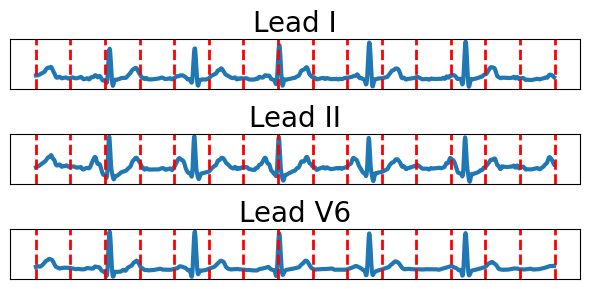

In [30]:
fig, axs = plt.subplots(figs, 1, figsize=(6, figs))

# 각 리드를 서브플롯으로 그리기
i = 0
for k, v in lead_dict.items():
    if k in except_list: continue
    axs[i].plot(samples[0][k][:1125], linewidth=3)
    axs[i].set_title(f'Lead {v}', fontsize=20)
    axs[i].set_xticks([])  # x축 눈금 제거
    axs[i].set_yticks([])  # y축 눈금 제거

    for x in range(0, 1125+1, 75):
        axs[i].axvline(x=x, color='r', linestyle='--', linewidth=2)
    
    i += 1

# 레이아웃 조정
plt.tight_layout()
plt.show()

## 마스킹 + 패치화

In [10]:
mask_tmp = torch.Tensor([[1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
         1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
         1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0.,
         1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
         1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1.,
         0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
         0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.],
        [0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
         1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
         1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
         1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0.]])

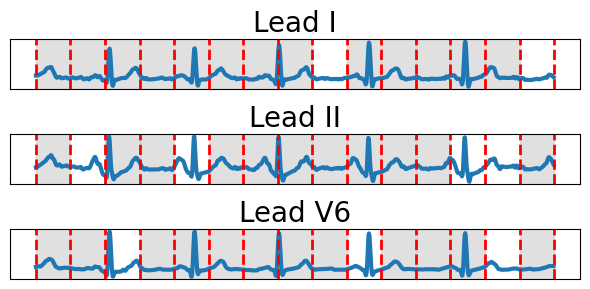

In [11]:
fig, axs = plt.subplots(figs, 1, figsize=(6, figs))

# 각 리드를 서브플롯으로 그리기
i = 0
for k, v in lead_dict.items():
    if k in except_list: continue
    axs[i].plot(samples[0][k][:1125], linewidth=3)
    axs[i].set_title(f'Lead {v}', fontsize=20)
    axs[i].set_xticks([])  # x축 눈금 제거
    axs[i].set_yticks([])  # y축 눈금 제거

    for x in range(0, 1125+1, 75):
        axs[i].axvline(x=x, color='r', linestyle='--', linewidth=2)

    for idx, check in enumerate(mask_tmp[k][:15]):
        if check == 0: continue
        start_x = idx * 75
        end_x = start_x + 75
        axs[i].axvspan(start_x, end_x, color='lightgray', edgecolor=None, alpha=0.7)  # 회색 배경, 투명도 30%
    
    i += 1

# 레이아웃 조정
plt.tight_layout()
plt.show()

## 순서 + 패치화

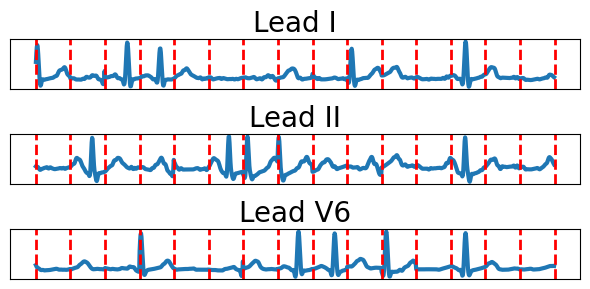

In [20]:
signal_length = 1125
patch_size = 75
num_patches = signal_length // patch_size
shuffle_fraction = 0.75

fig, axs = plt.subplots(figs, 1, figsize=(6, figs))

# 각 리드를 서브플롯으로 그리기
i = 0
for k, v in lead_dict.items():
    if k in except_list: continue
    signal = samples[0][k][:1125]

    # 패치화
    patches = [signal[j:j + patch_size] for j in range(0, signal_length, patch_size)]

    # 패치 중 75%를 섞음
    num_to_shuffle = int(num_patches * shuffle_fraction)
    patches_to_shuffle = patches[:num_to_shuffle]
    np.random.shuffle(patches_to_shuffle)  # 75% 섞기

    # 섞인 패치와 남은 패치를 합침
    shuffled_signal = np.concatenate(patches_to_shuffle + patches[num_to_shuffle:])

    # 섞인 신호 시각화
    axs[i].plot(shuffled_signal, linewidth=3)
    
    axs[i].set_title(f'Lead {v}', fontsize=20)
    axs[i].set_xticks([])  # x축 눈금 제거
    axs[i].set_yticks([])  # y축 눈금 제거

    for x in range(0, 1125+1, 75):
        axs[i].axvline(x=x, color='r', linestyle='--', linewidth=2)
    
    i += 1

# 레이아웃 조정
plt.tight_layout()
plt.show()

# 개별 시각화

## 마스킹 (모두) + 패치화)

In [70]:
mask_tmp = torch.Tensor([[1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
         1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
         1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0.,
         1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
         1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1.,
         0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
         0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.],
        [0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
         1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
         1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
         1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0.]])

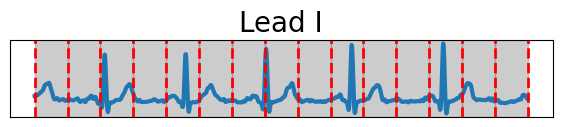

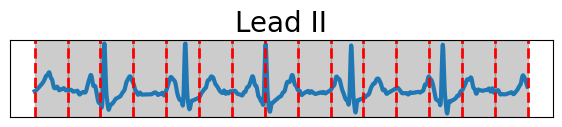

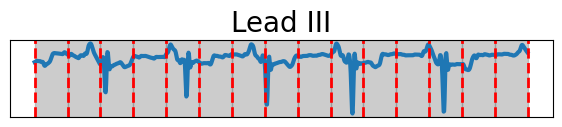

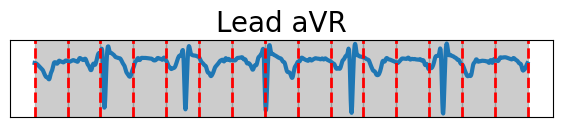

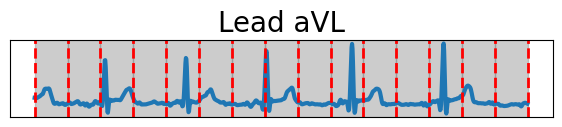

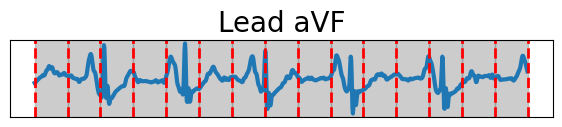

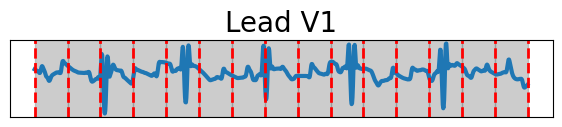

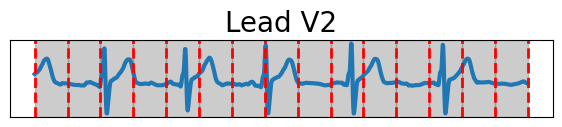

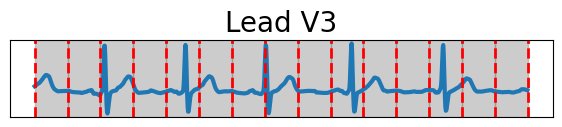

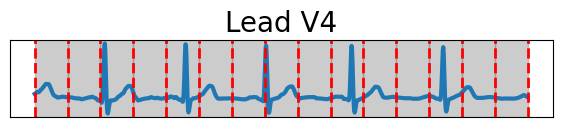

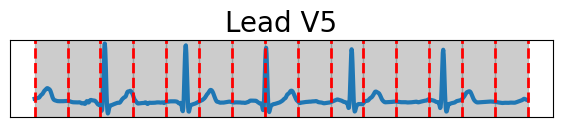

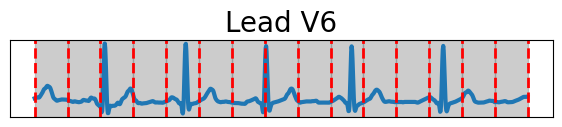

In [14]:
# 각 리드를 서브플롯으로 그리기
i = 0
for k, v in lead_dict.items():
    # if k in except_list: continue        
    plt.figure(figsize=(7, 1))
    plt.plot(samples[0][k][:1125], linewidth=3)
    plt.title(f'Lead {v}', fontsize=20)
    plt.xticks([])  # x축 눈금 제거
    plt.yticks([])  # y축 눈금 제거

    for x in range(0, 1125+1, 75):
        plt.axvline(x=x, color='r', linestyle='--', linewidth=2)

    for idx, check in enumerate(mask_tmp[k][:15]):
        # if check == 0: continue
        start_x = idx * 75
        end_x = start_x + 75
        plt.axvspan(start_x, end_x, color='gray', edgecolor=None, alpha=0.4)  # 회색 배경, 투명도 30%

    plt.show()
    i += 1

순서 같이 시각화

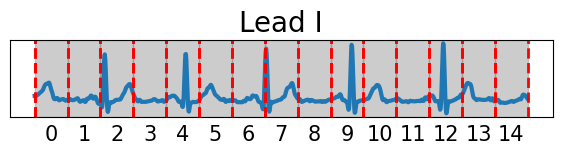

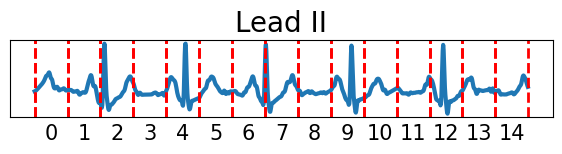

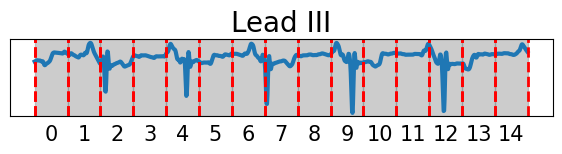

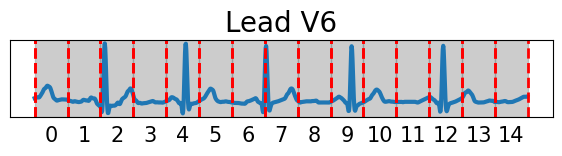

In [88]:
# 각 리드를 서브플롯으로 그리기
i = 0
msg_r = [-3, -2.5, -4.2, -2.8]

for k, v in lead_dict.items():
    if k in except_list: continue        
    plt.figure(figsize=(7, 1))
    plt.plot(samples[0][k][:1125], linewidth=3)
    plt.title(f'Lead {v}', fontsize=20)
    plt.xticks([])  # x축 눈금 제거
    plt.yticks([])  # y축 눈금 제거

    for x in range(0, 1125+1, 75):
        plt.axvline(x=x, color='r', linestyle='--', linewidth=2)

    if k != 1:
        for idx, check in enumerate(mask_tmp[k][:15]):
            # if check == 0: continue
            start_x = idx * 75
            end_x = start_x + 75
            plt.axvspan(start_x, end_x, color='gray', edgecolor=None, alpha=0.4)  # 회색 배경, 투명도 30%

    # 패치 경계선 및 순서 출력
    for idx in range(num_patches):
        x_pos = (idx + 0.5) * patch_size  # 패치 중앙 위치
        plt.axvline(x=idx * patch_size, color='r', linestyle='--', linewidth=2)  # 패치 경계선
        plt.text(x_pos, msg_r[i], str(order_tmp[idx]), fontsize=15, ha='center', va='top')  # 패치 중앙에 순서 출력

    plt.show()
    i += 1

## 원래 시각화 + 패치화

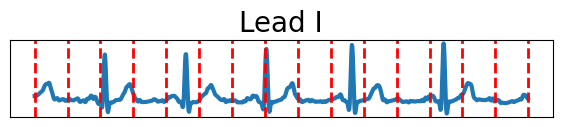

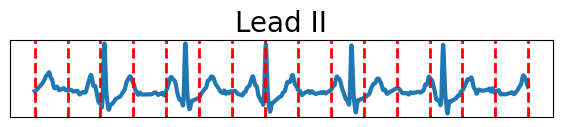

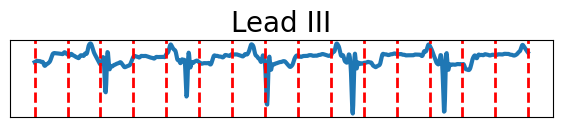

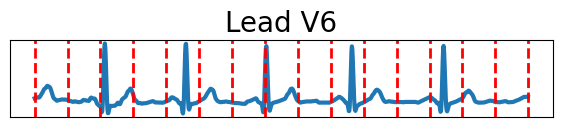

In [9]:
# 각 리드를 서브플롯으로 그리기
i = 0
for k, v in lead_dict.items():
    if k in except_list: continue
        
    plt.figure(figsize=(7, 1))
    plt.plot(samples[0][k][:1125], linewidth=3)
    plt.title(f'Lead {v}', fontsize=20)
    plt.xticks([])  # x축 눈금 제거
    plt.yticks([])  # y축 눈금 제거

    for x in range(0, 1125+1, 75):
        plt.axvline(x=x, color='r', linestyle='--', linewidth=2)

    plt.show()
    i += 1

## 마스킹 + 패치화

In [9]:
mask_tmp = torch.Tensor([[1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
         1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
         1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0.,
         1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
         1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1.,
         0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
         0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.],
        [0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
         1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
         1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
         1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0.]])

In [11]:
mask_tmp.shape

torch.Size([12, 30])

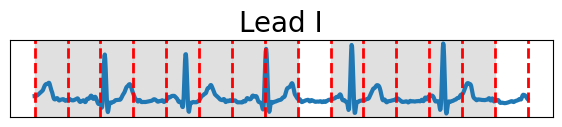

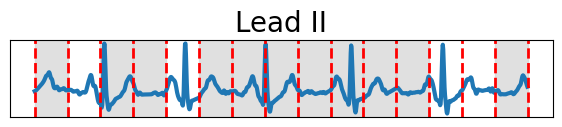

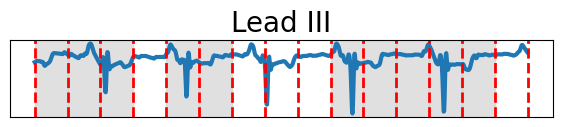

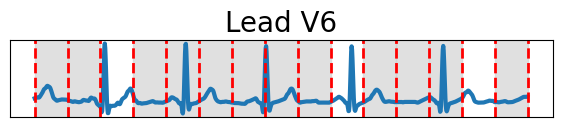

In [11]:
# 각 리드를 서브플롯으로 그리기
i = 0
for k, v in lead_dict.items():
    if k in except_list: continue

    plt.figure(figsize=(7, 1))
    plt.plot(samples[0][k][:1125], linewidth=3)
    plt.title(f'Lead {v}', fontsize=20)
    plt.xticks([])  # x축 눈금 제거
    plt.yticks([])  # y축 눈금 제거

    for x in range(0, 1125+1, 75):
        plt.axvline(x=x, color='r', linestyle='--', linewidth=2)

    for idx, check in enumerate(mask_tmp[k][:15]):
        if check == 0: continue
        start_x = idx * 75
        end_x = start_x + 75
        plt.axvspan(start_x, end_x, color='lightgray', edgecolor=None, alpha=0.7)  # 회색 배경, 투명도 30%
    
    plt.show()
    i += 1

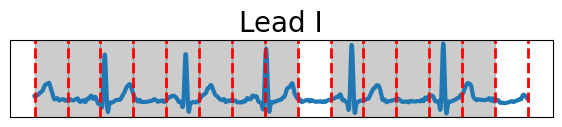

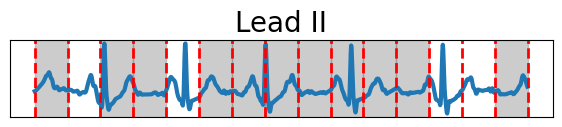

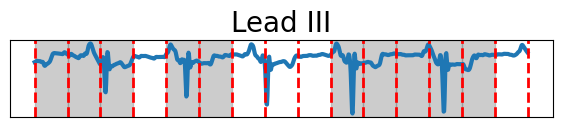

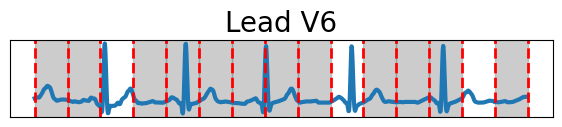

In [12]:
# 각 리드를 서브플롯으로 그리기
i = 0
for k, v in lead_dict.items():
    if k in except_list: continue

    plt.figure(figsize=(7, 1))
    plt.plot(samples[0][k][:1125], linewidth=3)
    plt.title(f'Lead {v}', fontsize=20)
    plt.xticks([])  # x축 눈금 제거
    plt.yticks([])  # y축 눈금 제거

    for x in range(0, 1125+1, 75):
        plt.axvline(x=x, color='r', linestyle='--', linewidth=2)

    for idx, check in enumerate(mask_tmp[k][:15]):
        if check == 0: continue
        start_x = idx * 75
        end_x = start_x + 75
        plt.axvspan(start_x, end_x, color='gray', edgecolor=None, alpha=0.4)  # 회색 배경, 투명도 30%
    
    plt.show()
    i += 1

순서도 같이 시각화

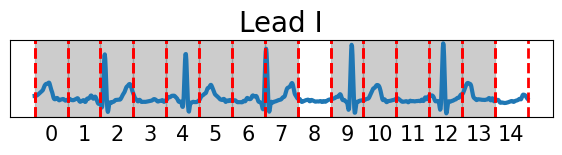

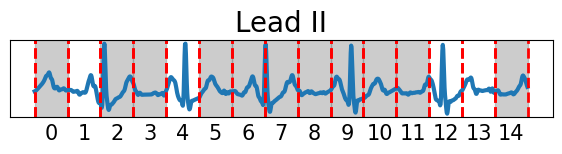

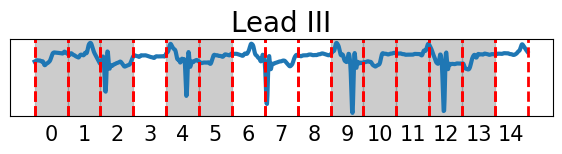

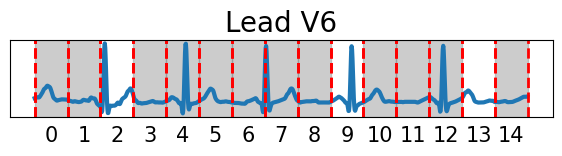

In [87]:
# 각 리드를 서브플롯으로 그리기
i = 0
msg_r = [-3, -2.5, -4.2, -2.8]

for k, v in lead_dict.items():
    if k in except_list: continue

    plt.figure(figsize=(7, 1))
    plt.plot(samples[0][k][:1125], linewidth=3)
    plt.title(f'Lead {v}', fontsize=20)
    plt.xticks([])  # x축 눈금 제거
    plt.yticks([])  # y축 눈금 제거

    for x in range(0, 1125+1, 75):
        plt.axvline(x=x, color='r', linestyle='--', linewidth=2)

    for idx, check in enumerate(mask_tmp[k][:15]):
        if check == 0: continue
        start_x = idx * 75
        end_x = start_x + 75
        plt.axvspan(start_x, end_x, color='gray', edgecolor=None, alpha=0.4)  # 회색 배경, 투명도 30%

    # 패치 경계선 및 순서 출력
    for idx in range(num_patches):
        x_pos = (idx + 0.5) * patch_size  # 패치 중앙 위치
        plt.axvline(x=idx * patch_size, color='r', linestyle='--', linewidth=2)  # 패치 경계선
        plt.text(x_pos, msg_r[i], str(order_tmp[idx]), fontsize=15, ha='center', va='top')  # 패치 중앙에 순서 출력
        
    plt.show()
    i += 1

## 순서 + 패치화

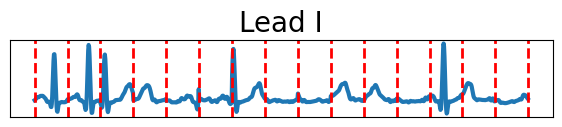

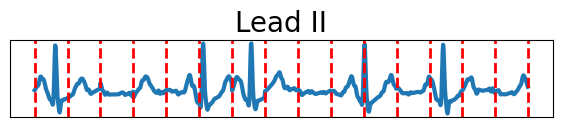

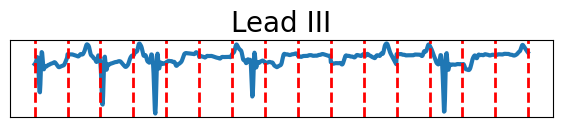

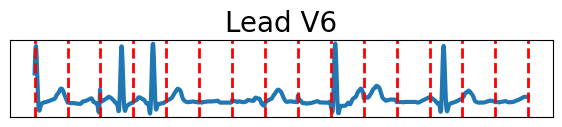

In [9]:
signal_length = 1125
patch_size = 75
num_patches = signal_length // patch_size
shuffle_fraction = 0.75

# 각 리드를 서브플롯으로 그리기
i = 0
for k, v in lead_dict.items():
    if k in except_list: continue
    signal = samples[0][k][:1125]

    # 패치화
    patches = [signal[j:j + patch_size] for j in range(0, signal_length, patch_size)]

    # 패치 중 75%를 섞음
    num_to_shuffle = int(num_patches * shuffle_fraction)
    patches_to_shuffle = patches[:num_to_shuffle]
    np.random.shuffle(patches_to_shuffle)  # 75% 섞기

    # 섞인 패치와 남은 패치를 합침
    shuffled_signal = np.concatenate(patches_to_shuffle + patches[num_to_shuffle:])

    plt.figure(figsize=(7, 1))
    
    # 섞인 신호 시각화
    plt.plot(shuffled_signal, linewidth=3)
    
    plt.title(f'Lead {v}', fontsize=20)
    plt.xticks([])  # x축 눈금 제거
    plt.yticks([])  # y축 눈금 제거

    for x in range(0, 1125+1, 75):
        plt.axvline(x=x, color='r', linestyle='--', linewidth=2)

    plt.show()
    i += 1

순서 같이 시각화

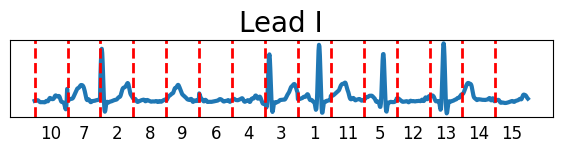

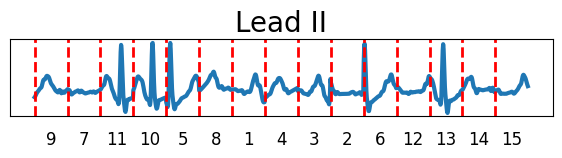

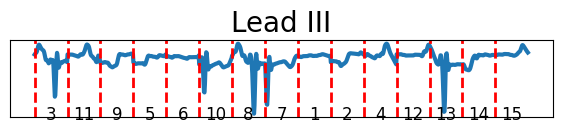

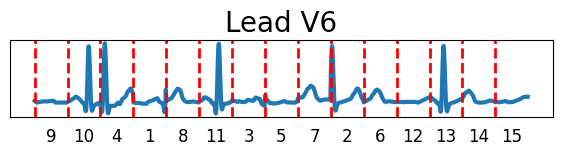

In [33]:
signal_length = 1125
patch_size = 75
num_patches = signal_length // patch_size
shuffle_fraction = 0.75

# 각 리드를 서브플롯으로 그리기
i = 0
for k, v in lead_dict.items():
    if k in except_list: continue
    signal = samples[0][k][:1125]

    # 패치화
    patches = [signal[j:j + patch_size] for j in range(0, signal_length, patch_size)]

    # 원래 순서 기록
    original_order = list(range(1, num_patches + 1))

    # 패치 중 75%를 섞음
    num_to_shuffle = int(num_patches * shuffle_fraction)
    patches_to_shuffle = patches[:num_to_shuffle]
    original_order_to_shuffle = original_order[:num_to_shuffle]

    np.random.shuffle(patches_to_shuffle)  # 75% 섞기
    np.random.shuffle(original_order_to_shuffle)  # 섞인 순서를 기록

    # 섞인 패치와 남은 패치를 합침
    shuffled_signal = np.concatenate(patches_to_shuffle + patches[num_to_shuffle:])
    shuffled_order = original_order_to_shuffle + original_order[num_to_shuffle:]

    plt.figure(figsize=(7, 1))
    
    # 섞인 신호 시각화
    plt.plot(shuffled_signal, linewidth=3)
    
    plt.title(f'Lead {v}', fontsize=20)
    plt.xticks([])  # x축 눈금 제거
    plt.yticks([])  # y축 눈금 제거

    # 패치 경계선 및 순서 출력
    for idx in range(num_patches):
        x_pos = (idx + 0.5) * patch_size  # 패치 중앙 위치
        plt.axvline(x=idx * patch_size, color='r', linestyle='--', linewidth=2)  # 패치 경계선
        plt.text(x_pos, -3, str(shuffled_order[idx]), fontsize=12, ha='center', va='top')  # 패치 중앙에 순서 출력

    plt.show()
    i += 1

In [15]:
' '.join(map(str, np.arange(15)))

'0 1 2 3 4 5 6 7 8 9 10 11 12 13 14'

In [10]:
shuffled_order

[11, 7, 9, 13, 8, 10, 4, 15, 14, 12, 5, 3, 2, 1, 6]

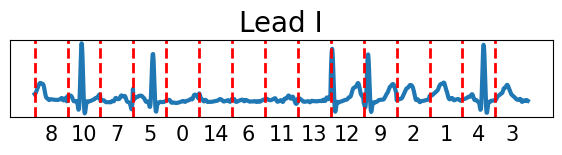

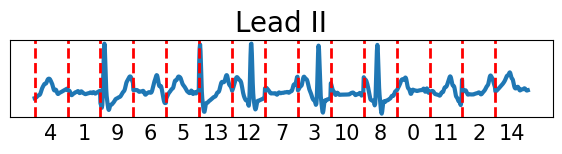

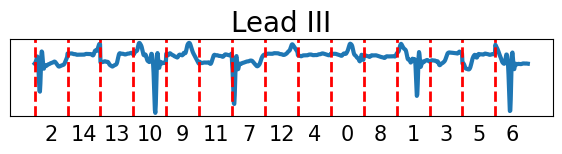

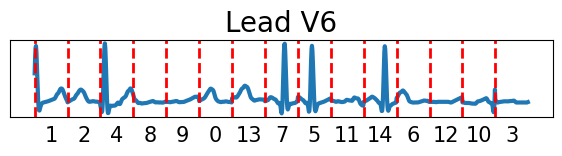

In [11]:
msg_r = [-3, -2.5, -4.2, -2.8]
signal_length = 1125
patch_size = 75
num_patches = signal_length // patch_size
shuffle_fraction = 1

# 각 리드를 서브플롯으로 그리기
i = 0
for k, v in lead_dict.items():
    if k in except_list: continue
    signal = samples[0][k][:1125]

    # 패치화
    patches = [signal[j:j + patch_size] for j in range(0, signal_length, patch_size)]

    # 원래 순서 기록
    original_order = list(range(1, num_patches + 1))

    # 패치 중 75%를 섞음
    num_to_shuffle = int(num_patches * shuffle_fraction)
    patches_to_shuffle = patches[:num_to_shuffle]
    original_order_to_shuffle = original_order[:num_to_shuffle]

    np.random.shuffle(patches_to_shuffle)  # 75% 섞기
    np.random.shuffle(original_order_to_shuffle)  # 섞인 순서를 기록

    # 섞인 패치와 남은 패치를 합침
    shuffled_signal = np.concatenate(patches_to_shuffle + patches[num_to_shuffle:])
    shuffled_order = original_order_to_shuffle + original_order[num_to_shuffle:]
    shuffled_order2 = [item_ - 1 for item_ in shuffled_order]

    plt.figure(figsize=(7, 1))
    
    # 섞인 신호 시각화
    plt.plot(shuffled_signal, linewidth=3)
    
    plt.title(f'Lead {v}', fontsize=20)
    plt.xticks([])  # x축 눈금 제거
    plt.yticks([])  # y축 눈금 제거

    # 패치 경계선 및 순서 출력
    for idx in range(num_patches):
        x_pos = (idx + 0.5) * patch_size  # 패치 중앙 위치
        plt.axvline(x=idx * patch_size, color='r', linestyle='--', linewidth=2)  # 패치 경계선
        plt.text(x_pos, msg_r[i], str(shuffled_order2[idx]), fontsize=15, ha='center', va='top')  # 패치 중앙에 순서 출력

    plt.show()
    i += 1

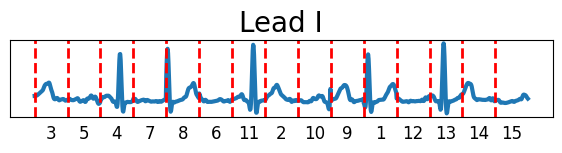

In [36]:
# 패치화
k = 0
v = lead_dict[k]

signal = samples[0][k][:1125]
patches = [signal[j:j + patch_size] for j in range(0, signal_length, patch_size)]

# 원래 순서 기록
original_order = list(range(1, num_patches + 1))

# 패치 중 75%를 섞음
num_to_shuffle = int(num_patches * shuffle_fraction)
patches_to_shuffle = patches[:num_to_shuffle]
original_order_to_shuffle = original_order[:num_to_shuffle]

np.random.shuffle(patches_to_shuffle)  # 75% 섞기
np.random.shuffle(original_order_to_shuffle)  # 섞인 순서를 기록

# 섞인 패치와 남은 패치를 합침
shuffled_signal = np.concatenate(patches_to_shuffle + patches[num_to_shuffle:])
shuffled_order = original_order_to_shuffle + original_order[num_to_shuffle:]

plt.figure(figsize=(7, 1))

# 섞인 신호 시각화
plt.plot(shuffled_signal, linewidth=3)

plt.title(f'Lead {v}', fontsize=20)
plt.xticks([])  # x축 눈금 제거
plt.yticks([])  # y축 눈금 제거

# 패치 경계선 및 순서 출력
for idx in range(num_patches):
    x_pos = (idx + 0.5) * patch_size  # 패치 중앙 위치
    plt.axvline(x=idx * patch_size, color='r', linestyle='--', linewidth=2)  # 패치 경계선
    plt.text(x_pos, -3, str(shuffled_order[idx]), fontsize=12, ha='center', va='top')  # 패치 중앙에 순서 출력

plt.show()
i += 1

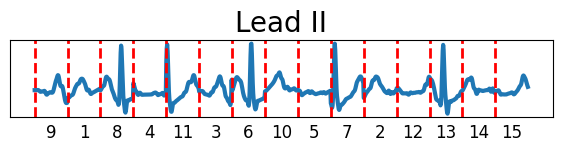

In [41]:
# 패치화
k = 1
v = lead_dict[k]

signal = samples[0][k][:1125]
patches = [signal[j:j + patch_size] for j in range(0, signal_length, patch_size)]

# 원래 순서 기록
original_order = list(range(1, num_patches + 1))

# 패치 중 75%를 섞음
num_to_shuffle = int(num_patches * shuffle_fraction)
patches_to_shuffle = patches[:num_to_shuffle]
original_order_to_shuffle = original_order[:num_to_shuffle]

np.random.shuffle(patches_to_shuffle)  # 75% 섞기
np.random.shuffle(original_order_to_shuffle)  # 섞인 순서를 기록

# 섞인 패치와 남은 패치를 합침
shuffled_signal = np.concatenate(patches_to_shuffle + patches[num_to_shuffle:])
shuffled_order = original_order_to_shuffle + original_order[num_to_shuffle:]

plt.figure(figsize=(7, 1))

# 섞인 신호 시각화
plt.plot(shuffled_signal, linewidth=3)

plt.title(f'Lead {v}', fontsize=20)
plt.xticks([])  # x축 눈금 제거
plt.yticks([])  # y축 눈금 제거

# 패치 경계선 및 순서 출력
for idx in range(num_patches):
    x_pos = (idx + 0.5) * patch_size  # 패치 중앙 위치
    plt.axvline(x=idx * patch_size, color='r', linestyle='--', linewidth=2)  # 패치 경계선
    plt.text(x_pos, -2.5, str(shuffled_order[idx]), fontsize=12, ha='center', va='top')  # 패치 중앙에 순서 출력

plt.show()
i += 1

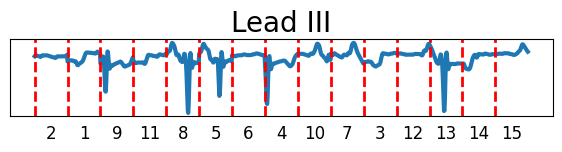

In [44]:
# 패치화
k = 2
v = lead_dict[k]

signal = samples[0][k][:1125]
patches = [signal[j:j + patch_size] for j in range(0, signal_length, patch_size)]

# 원래 순서 기록
original_order = list(range(1, num_patches + 1))

# 패치 중 75%를 섞음
num_to_shuffle = int(num_patches * shuffle_fraction)
patches_to_shuffle = patches[:num_to_shuffle]
original_order_to_shuffle = original_order[:num_to_shuffle]

np.random.shuffle(patches_to_shuffle)  # 75% 섞기
np.random.shuffle(original_order_to_shuffle)  # 섞인 순서를 기록

# 섞인 패치와 남은 패치를 합침
shuffled_signal = np.concatenate(patches_to_shuffle + patches[num_to_shuffle:])
shuffled_order = original_order_to_shuffle + original_order[num_to_shuffle:]

plt.figure(figsize=(7, 1))

# 섞인 신호 시각화
plt.plot(shuffled_signal, linewidth=3)

plt.title(f'Lead {v}', fontsize=20)
plt.xticks([])  # x축 눈금 제거
plt.yticks([])  # y축 눈금 제거

# 패치 경계선 및 순서 출력
for idx in range(num_patches):
    x_pos = (idx + 0.5) * patch_size  # 패치 중앙 위치
    plt.axvline(x=idx * patch_size, color='r', linestyle='--', linewidth=2)  # 패치 경계선
    plt.text(x_pos, -4.2, str(shuffled_order[idx]), fontsize=12, ha='center', va='top')  # 패치 중앙에 순서 출력

plt.show()
i += 1

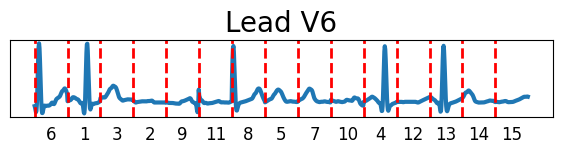

In [45]:
# 패치화
k = 11
v = lead_dict[k]

signal = samples[0][k][:1125]
patches = [signal[j:j + patch_size] for j in range(0, signal_length, patch_size)]

# 원래 순서 기록
original_order = list(range(1, num_patches + 1))

# 패치 중 75%를 섞음
num_to_shuffle = int(num_patches * shuffle_fraction)
patches_to_shuffle = patches[:num_to_shuffle]
original_order_to_shuffle = original_order[:num_to_shuffle]

np.random.shuffle(patches_to_shuffle)  # 75% 섞기
np.random.shuffle(original_order_to_shuffle)  # 섞인 순서를 기록

# 섞인 패치와 남은 패치를 합침
shuffled_signal = np.concatenate(patches_to_shuffle + patches[num_to_shuffle:])
shuffled_order = original_order_to_shuffle + original_order[num_to_shuffle:]

plt.figure(figsize=(7, 1))

# 섞인 신호 시각화
plt.plot(shuffled_signal, linewidth=3)

plt.title(f'Lead {v}', fontsize=20)
plt.xticks([])  # x축 눈금 제거
plt.yticks([])  # y축 눈금 제거

# 패치 경계선 및 순서 출력
for idx in range(num_patches):
    x_pos = (idx + 0.5) * patch_size  # 패치 중앙 위치
    plt.axvline(x=idx * patch_size, color='r', linestyle='--', linewidth=2)  # 패치 경계선
    plt.text(x_pos, -2.8, str(shuffled_order[idx]), fontsize=12, ha='center', va='top')  # 패치 중앙에 순서 출력

plt.show()
i += 1